# Coronavirus Prevalence

## Introduction

On April 22, Drs. Erickson and Massihi from Kern County California gave a controversial press briefing where they detailed the testing statistics from their healthcare facilities and made some observations as to what they thought the prevalence and fatality rate of coronavirus might be. And they suggested lifting the lockdown. Their unorthodox methodology for estimating the prevalence of coronavirus was criticized in articles and on twitter. Their [press briefing](https://www.turnto23.com/news/coronavirus/video-interview-with-dr-dan-erickson-and-dr-artin-massihi-taken-down-from-youtube) was eventually censored from Youtube.

Anyway...that dangerous misinformation prompted me to put on my data science hat and ask some questions:

- What is the prevalence of coronavirus?
- How can we estimate the prevalence of coronavirus?
- How can we combine diagnostic testing data and antibody seroprevalence studies?
- How can we evaluate the quality of an estimate?

I care about the fatality rate of the virus because I want to know:

- How does coronavirus compare to other kinds of individual risks?
- How many people might die overall during the pandemic?

Two kinds of fatality rates capture different measures of individual risk and societal burden, infection fatality rate and mortality rate.

These rates can help us understand what an individual's risk of dying will be 
Both of these fatality rates allow us to compare coronavirus to other personal risks and societal burdens we face.

I care about the fatality rate of the virus because I want to know:

- How does coronavirus compare to other kinds of individual risks?
- How many people might die overall during the pandemic?

Wanting the answers to these questions, I wanted to know:

- What is the infection fatality rate (IFR) of coronavirus?
- How does that IFR vary by state, age and underlying conditions?
- How many people will die overall?
- How will that vary by state, age and underlying conditions?


### Definitions

"Cases" are the number of people who have tested positive for coronavirus, sometimes called confirmed cases. 

"Deaths" are the number of people who have died from coronavirus. 

"Infections" are the number of people who have been infected at some point with coronavirus

"Tests" are the number of people (or some states report specimens) that have been tested.

Prevalence is the percent (or count) of people who have been infected with coronavirus. It helps us to:

- understand how deadly the virus is.
- know when we might achieve herd immunity.

Case Fatality Rate (CFR) is the ratio of deaths to cases. This is generally considered pessimistic, since the people getting tested are often already quite sick.

Infection Fatality Rate (IFR) is the ratio of deaths to infections, where , even if they were not tested.

CFR and IFR are very different for coronavirus. Why? We know that many or most coronavirus infections are mild or asymptomatic and that these infections are rarely tested. Initial testing focused on diagnosing people who were seriously ill and coming into the healthcare system for treatment.

Mortality Rate (MR) is deaths per capita. It measures the burden of a disease on the population as a whole. The CDC reports mortality rate per 100,000 for influenza at https://www.cdc.gov/flu/about/burden/past-seasons.html. Mortality rate is useful because it lets us compare the current or final burden of coronavirus to other population-level burdens we face, like suicide, cancer, car accidents or other illnesses like influenza. Also, unlike IFR, mortality rate does not require an estimate of infections, only population estimates. This should make it easier to estimate, more accurate, and robust to noise than IFR.

## Evidence of Prevalence

Empirical evidence of the prevalence of coronavirus came in late April from several antibody seroprevalence studies done in the United States, one in Santa Clara (CA) county, one in LA county (CA), one in Miami Dade County (FL) and one in New York state. The IFR implied by the New York study was also around 0.5%. [ref](https://www.livescience.com/covid-antibody-test-results-new-york-test.html)

Early empirical evidence of the IFR came during the month of February, when the Diamond Princess cruise ship was languishing in port in Japan while suffering a widespread outbreak of coronavirus. Everyone on the ship was tested. This is some of the earliest data that provided an estimate of the Infection Fatality Rate. On March 26th, Nature published the Infecton Fatality Rate estimate of 0.5% (https://www.nature.com/articles/d41586-020-00885-w):

> The group also estimates that the infection fatality rate (IFR) in China — the proportion of all infections, including asymptomatic ones, that result in death — is even lower, at roughly 0.5%. The IFR is especially tricky to calculate in the population, because some deaths go undetected if the person didn’t show symptoms or get tested.

Empirical evidence of the IFR of coronavirus came from an antibody seroprevalence study in New York state. The study results implied an IFR around 0.5%. [ref](https://www.livescience.com/covid-antibody-test-results-new-york-test.html)


## Estimation of Prevalence

In this work we used a baseline method to estimate the number of infections on a per-state basis. We assume that the number of cases in a state is proportional to the number of infections in the state. It seems like it might be a rough approximation useful for making aggregate ballpark estimates.

$$
\text{infections} = \beta * \text{cases}
$$

TODO: find evidence supporting the model of infections being proportional to cases.

The coefficient $\beta$ is estimated from seroprevalence surveys that publish number of cases and the number of infections or prevalence and population size.

We have information for the following surveys:

- NY state announced on 05/02 study results showing that the state-wide seroprevalence was 12.3%. Using cases and population data, we estimate that $\beta = 8$. [data](https://www.governor.ny.gov/news/amid-ongoing-covid-19-pandemic-governor-cuomo-announces-results-completed-antibody-testing)
- Miami-Date county announced on 04/24 study results showing that the county-wide seroprevalence was 6%. Using that seroprevalence data, we estimate that $\beta = 16$. [data](https://www.miamidade.gov/releases/2020-04-24-sample-testing-results.asp)


### Vulnerable Populations

Coronavirus strikes hardest elderly people and people with certain underlying conditions. Knowing the IFR among these segments of people can help us understand more finely the risk to specific individuals. This has implication for who we focus on protecting and how we protect them.



## Results

In [331]:
import datetime
import itertools
from pprint import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import pandas as pd
from pandas import to_datetime
from pathlib import Path
import plotly.express as px
from scipy.special import gamma
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
import time
import timeit

from IPython.display import HTML 
from coronavirus import data
from coronavirus.data import (
    load_cdc_deaths_by_age,
    load_census_state_population_by_age_data,
    load_covidtracking_state_data, 
    load_nyc_age_comorbidity_death_data, 
    load_ma_data_by_date_age,
    load_ri_data_by_date_age,
    load_cdc_influenza_burden_by_age,
    load_seroprevalence,
    fill_before_first, before_threshold, make_days_since,
    add_derived_values_cols,
    to_prevalence_dataframe,
    add_age_dimension,
    add_condition_dimension,
    add_herd_cols,
    add_herd_dimension,
    add_infections_dimension,
    add_ifr_cols,
    add_prevalence_cols,
    add_prevalence_dimension,
    MA_CONDITION_P,
    NYC_CONDITION_P,
    seroprevalence_adjustments
)
from coronavirus.viz import plot_trajectories, days_since_trim, prioritize_entities, format_for_display


%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [340]:
states_df = (load_covidtracking_state_data(download=False, cache=True)
             .pipe(add_derived_values_cols))
# takes a few seconds to load
pop_nyc = load_census_state_population_by_age_data(bands='nyc')
_, dc_nyc = load_nyc_age_comorbidity_death_data()

pop_ma = load_census_state_population_by_age_data(bands='ma')
dc_ma = load_ma_data_by_date_age().groupby('age_band').last().reset_index()

pop_ri = pop_ma
dc_ri = load_ri_data_by_date_age(bands='ma').groupby('age_band').last().reset_index()

sero = load_seroprevalence()

### Prevalence in the United States



In [341]:
df = states_df
df = df.loc[:, ['date', 'entity', 'deaths', 'cases', 'tests', 'population']]
df = add_infections_dimension(df)
methods = ['confirmed', 'ny_confirmed', 'miami_confirmed', 'az_confirmed']
df = df.loc[df['method'].isin(methods), :]
# summarize across entities
df = df.groupby(['date', 'method'])[['deaths', 'infections', 'cases', 'tests', 'population']].sum().reset_index()
df['entity'] = 'United States'
# display
df['prevalence'] = (df['infections'] / df['population']).apply(lambda x: f'{x:.6f}')
df['ifr'] = (df['deaths'] / df['infections']).apply(lambda x: f'{x:.6f}')
df['cfr'] = (df['deaths'] / df['cases']).apply(lambda x: f'{x:.6f}')
df['mr'] = (df['deaths'] / df['population']).apply(lambda x: f'{x:.6f}')
df = df.groupby(['entity', 'method']).last().reset_index()
print('Table: ')
display(df.loc[:, ['entity', 'date', 'method', 'prevalence', 'ifr', 'cfr', 'mr', 'infections', 
                   'population', 'tests', 'cases',  'deaths']])

Table: 


,entity,date,method,prevalence,ifr,cfr,mr,infections,population,tests,cases,deaths
0,United States,2020-05-20,az_confirmed,0.085281,0.003094,0.056716,0.000264,28264851.0,331433217,12640442,1542054.0,87459.0
1,United States,2020-05-20,confirmed,0.004653,0.056716,0.056716,0.000264,1542054.0,331433217,12640442,1542054.0,87459.0
2,United States,2020-05-20,miami_confirmed,0.072424,0.003644,0.056716,0.000264,24003670.0,331433217,12640442,1542054.0,87459.0
3,United States,2020-05-20,ny_confirmed,0.035571,0.007418,0.056716,0.000264,11789393.0,331433217,12640442,1542054.0,87459.0


### Prevalence by State

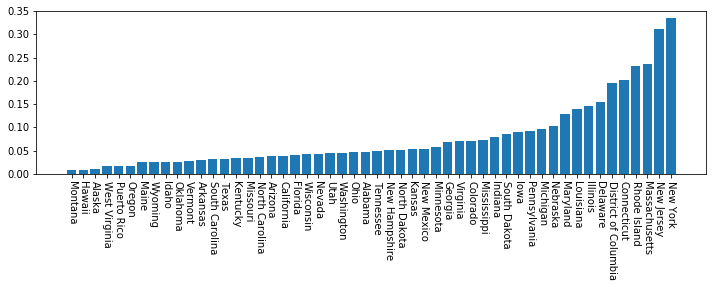

Table: 


,entity,date,method,prevalence,ifr,cfr,mr,infections,population,tests,cases,deaths
106,Montana,2020-05-20,miami_confirmed,0.006962,0.002150,0.033473,0.000015,7441.0,1068778,29726,478.0,16.0
46,Hawaii,2020-05-20,miami_confirmed,0.007047,0.001704,0.026521,0.000012,9978.0,1415872,46304,641.0,17.0
6,Alaska,2020-05-20,miami_confirmed,0.008554,0.001598,0.024876,0.000014,6258.0,731545,37045,402.0,10.0
198,West Virginia,2020-05-20,miami_confirmed,0.013420,0.002869,0.044660,0.000039,24050.0,1792147,80641,1545.0,69.0
158,Puerto Rico,2020-05-20,miami_confirmed,0.013969,0.002802,0.043615,0.000039,44612.0,3193694,2866,2866.0,125.0
150,Oregon,2020-05-20,miami_confirmed,0.014028,0.002434,0.037885,0.000034,59167.0,4217737,102149,3801.0,144.0
78,Maine,2020-05-20,miami_confirmed,0.021064,0.002578,0.040132,0.000054,28315.0,1344212,37269,1819.0,73.0
206,Wyoming,2020-05-20,miami_confirmed,0.021166,0.000898,0.013977,0.000019,12250.0,578759,18840,787.0,11.0
50,Idaho,2020-05-20,miami_confirmed,0.021567,0.001998,0.031099,0.000043,38542.0,1787065,38567,2476.0,77.0
146,Oklahoma,2020-05-20,miami_confirmed,0.021762,0.003472,0.054049,0.000076,86111.0,3956971,144371,5532.0,299.0


In [349]:
df = states_df
df = df.loc[:, ['date', 'entity', 'deaths', 'cases', 'tests', 'population']]
df = add_infections_dimension(df)
methods = [
    'ny_confirmed',  # pessimistic for most states, I think, but tuned for NY. Might be better for higher prevalence states like RI.
    'miami_confirmed',  # maybe best estimate for most states, perhaps lower prevalence states like CA or AZ.
    'confirmed',  # most pessimistic for all states
    'az_confirmed', # similar to miami_confirmed, based on AZ serology data
]
df = df.loc[df['method'].isin(methods), :]
df['prevalence'] = df['infections'] / df['population']
df = df.groupby(['entity', 'method']).last().reset_index().sort_values('prevalence')
plt.subplots(figsize=(12, 3))
plt.bar(df['entity'], df['prevalence'])
plt.xticks(rotation=-90)
plt.show()
print('Table: ')
df['prevalence'] = df['prevalence'].apply(lambda x: f'{x:.6f}')
df['ifr'] = (df['deaths'] / df['infections']).apply(lambda x: f'{x:.6f}')
df['cfr'] = (df['deaths'] / df['cases']).apply(lambda x: f'{x:.6f}')
df['mr'] = (df['deaths'] / df['population']).apply(lambda x: f'{x:.6f}')
display(df.loc[
#     df['entity'] == 'Wyoming'
#     :
    df['method'] == 'miami_confirmed'
    , 
    ['entity', 'date', 'method', 'prevalence', 'ifr', 'cfr', 'mr', 'infections', 
     'population', 'tests', 'cases',  'deaths']])
# df

## Prevalence by Age in the United States


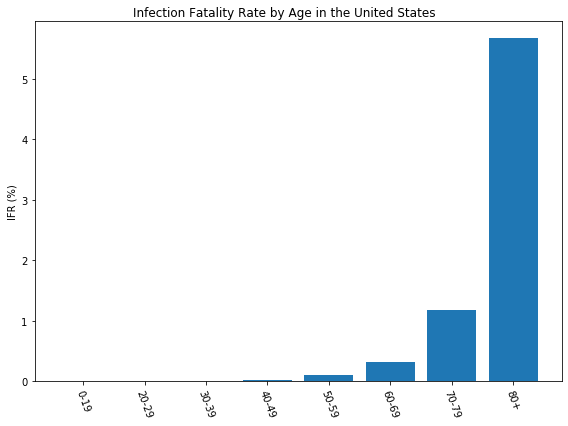

Table: Infection Fatality Rate by Age in the United States


prevalence  \
entity        date       method       age_method age_band              
United States 2020-05-20 ny_confirmed ma_age     0-19       0.034994   
                                                 20-29      0.035799   
                                                 30-39      0.035825   
                                                 40-49      0.035845   
                                                 50-59      0.036876   
                                                 60-69      0.036169   
                                                 70-79      0.035770   
                                                 80+        0.037422   
                                      ny_age     0 to 17    0.034941   
                                                 18 to 44   0.035753   
                                                 45 to 64   0.036568   
                                                 65 to 74   0.035769   
                                                 75+        0.036786   
                                      ri_age     0-19       0.034994   
                                                 20-29      0.035799   
                                                 30-39      0.035825   
                                                 40-49      0.035845   
                                                 50-59      0.036876   
                                                 60-69      0.036169   
                                                 70-79      0.035770   
                                                 80+        0.037422   

                                                                ifr       cfr  \
entity        date       method       age_method age_band                       
United States 2020-05-20 ny_confirmed ma_age     0-19      0.000000  0.000000   
                                                 20-29     0.000036  0.000308   
                                                 30-39     0.000164  0.001131   
                                                 40-49     0.000516  0.003365   
                                                 50-59     0.001958  0.012212   
                                                 60-69     0.006404  0.041824   
                                                 70-79     0.024089  0.133460   
                                                 80+       0.115372  0.233829   
                                      ny_age     0 to 17   0.000015  0.001106   
                                                 18 to 44  0.000843  0.006251   
                                                 45 to 64  0.006336  0.034352   
                                                 65 to 74  0.019780  0.112532   
                                                 75+       0.052628  0.242071   
                                      ri_age     0-19      0.000000  0.000000   
                                                 20-29     0.000383  0.002763   
                                                 30-39     0.000597  0.003912   
                                                 40-49     0.000644  0.003977   
                                                 50-59     0.002761  0.017489   
                                                 60-69     0.007135  0.054353   
                                                 70-79     0.027265  0.185623   
                                                 80+       0.102163  0.261219   

                                                                 mr  \
entity        date       method       age_method age_band             
United States 2020-05-20 ny_confirmed ma_age     0-19      0.000000   
                                                 20-29     0.000001   
                                                 30-39     0.000006   
                                                 40-49     0.000018   
                                                 50-59     0.000072   
                                        

In [345]:
df = states_df
df = df.loc[:, ['date', 'entity', 'deaths', 'cases', 'tests', 'population']]
df = add_infections_dimension(df)
df = add_age_dimension(df, pops=[pop_nyc, pop_ma, pop_ri], dcs=[dc_nyc, dc_ma, dc_ri])
methods = ['confirmed', 'ny_confirmed', 'miami_confirmed', 'az_confirmed']
df = df.loc[df['method'].isin(methods), :]
age_methods = ['ny_age', 'ma_age', 'ri_age']
df = df.loc[df['age_method'].isin(age_methods), :]
# summarize across entities
df = df.groupby(['date', 'method', 
                 'age_method', 'age_band'
                ])[['deaths', 'infections', 'cases', 'tests', 'population']].sum().reset_index()
df['entity'] = 'United States'

df = add_ifr_cols(df)


df = df.groupby(['entity', 'method', 
                 'age_method', 'age_band'
                ]).last().reset_index()

# plot IFR
method = 'miami_confirmed'
age_method = 'ma_age'
fig, ax = plt.subplots(figsize=(8, 6))
age_bands = df.loc[(df['method'] == method) & (df['age_method'] == age_method), 'age_band']
ifr = df.loc[(df['method'] == method) & (df['age_method'] == age_method), 'ifr'] * 100
ax.bar(age_bands, ifr)
ax.tick_params(axis='x', rotation=-70)
ax.set_ylabel('IFR (%)')
# ax.set_title(f'{method} {age_method}')
fig.suptitle('Infection Fatality Rate by Age in the United States')
fig.tight_layout(rect=(0, 0, 1, .97)) 
# fig.tight_layout() 
plt.show()

# Display Table
df = format_for_display(df)
print('Table: Infection Fatality Rate by Age in the United States')
display(df.loc[
    (df['method'] == 'ny_confirmed') 
#     & (df['age_method'] == 'ma_age')
    , 
    ['entity', 'date', 'method', 
                   'age_method', 'age_band', 
                   'prevalence', 'ifr', 'cfr', 'mr', 'infections', 
                   'population', 'tests', 'cases',  'deaths']]
       .groupby(['entity', 'date', 'method', 'age_method', 'age_band']).last())


## Prevalence by Age and State


In [348]:
df = states_df
df = df.loc[:, ['date', 'entity', 'deaths', 'cases', 'tests', 'population']]
df = add_infections_dimension(df)
df = add_age_dimension(df, pops=[pop_nyc, pop_ma, pop_ri], dcs=[dc_nyc, dc_ma, dc_ri])
df = add_ifr_cols(df)
# most recent date
df = df.groupby(['entity', 'method', 
                 'age_method', 'age_band'
                ]).last().reset_index()

# display
df = format_for_display(df)
print('Table: Infection Fatality Rate by Age and State')
display(df.loc[
    (df['method'] == 'ny_confirmed') 
    & (df['age_method'] == 'ri_age')
    & (df['entity'].isin(['Massachusetts', 'Utah']))
    , 
    ['entity', 'date', 'method', 
                   'age_method', 'age_band', 
                   'prevalence', 'ifr', 'cfr', 'mr', 'infections', 
                   'population', 'tests', 'cases',  'deaths']]
       .groupby(['entity', 'date', 'method', 'age_method', 'age_band']).last())


Table: Infection Fatality Rate by Age and State


prevalence  \
entity        date       method       age_method age_band              
Massachusetts 2020-05-20 ny_confirmed ri_age     0-19       0.098687   
                                                 20-29      0.098687   
                                                 30-39      0.098687   
                                                 40-49      0.098687   
                                                 50-59      0.098687   
                                                 60-69      0.098687   
                                                 70-79      0.098687   
                                                 80+        0.098687   
Utah          2020-05-20 ny_confirmed ri_age     0-19       0.018386   
                                                 20-29      0.018386   
                                                 30-39      0.018386   
                                                 40-49      0.018386   
                                                 50-59      0.018386   
                                                 60-69      0.018386   
                                                 70-79      0.018386   
                                                 80+        0.018386   

                                                                ifr       cfr  \
entity        date       method       age_method age_band                       
Massachusetts 2020-05-20 ny_confirmed ri_age     0-19      0.000000  0.000000   
                                                 20-29     0.000440  0.003320   
                                                 30-39     0.000714  0.004701   
                                                 40-49     0.000782  0.004778   
                                                 50-59     0.003178  0.021015   
                                                 60-69     0.008388  0.065312   
                                                 70-79     0.032581  0.223048   
                                                 80+       0.117305  0.313885   
Utah          2020-05-20 ny_confirmed ri_age     0-19      0.000000  0.000000   
                                                 20-29     0.000068  0.000568   
                                                 30-39     0.000115  0.000805   
                                                 40-49     0.000138  0.000818   
                                                 50-59     0.000793  0.003598   
                                                 60-69     0.002025  0.011182   
                                                 70-79     0.008045  0.038188   
                                                 80+       0.034172  0.053740   

                                                                 mr  \
entity        date       method       age_method age_band             
Massachusetts 2020-05-20 ny_confirmed ri_age     0-19      0.000000   
                                                 20-29     0.000043   
                                                 30-39     0.000070   
                                                 40-49     0.000077   
                                                 50-59     0.000314   
                                                 60-69     0.000828   
                                                 70-79     0.003215   
                                                 80+       0.011576   
Utah          2020-05-20 ny_confirmed ri_age     0-19      0.000000   
                                                 20-29     0.000001   
                                                 30-39     0.000002   
                                                 40-49     0.000003   
                                                 50-59     0.000015   
                                                 60-69     0.000037   
                                                 70-79     0.000148   
                                                 80+       0.000628   

                       

## Fatalities at Herd Immunity in the United States


In [381]:
df = states_df
df = df.loc[:, ['date', 'entity', 'deaths', 'cases', 'tests', 'population']]
df = add_infections_dimension(df)
# summarize across entities
df = df.groupby(['date', 'method'])[
    ['deaths', 'infections', 'cases', 'tests', 'population']].sum().reset_index()
df['entity'] = 'United States'
# add derived columns
df = add_ifr_cols(df)
df = add_herd_cols(df, herd_prevalence=0.4)
# most recent date
df = df.groupby(['entity', 'method']).last().reset_index()

# Display Table
df = format_for_display(df)
print('Table: Infection Fatality Rate in the United States')
display(df.loc[
#     (df['method'] == 'miami_confirmed') 
    :
    , 
    ['entity', 'date', 'method', 
     'prevalence', 'ifr', 'cfr', 'mr', 'infections', 
     'population', 'tests', 'cases',  'deaths', 
     'herd_prevalence', 'herd_infections', 'herd_deaths', 'herd_mr']]
       .groupby(['entity', 'date', 'method', 'herd_prevalence']).last())


Table: Infection Fatality Rate in the United States


prevalence       ifr  \
entity        date       method          herd_prevalence                        
United States 2020-05-20 az_confirmed    0.4               0.085281  0.003094   
                         confirmed       0.4               0.004653  0.056716   
                         miami_confirmed 0.4               0.072424  0.003644   
                         ny_confirmed    0.4               0.035571  0.007418   

                                                               cfr        mr  \
entity        date       method          herd_prevalence                       
United States 2020-05-20 az_confirmed    0.4              0.056716  0.000264   
                         confirmed       0.4              0.056716  0.000264   
                         miami_confirmed 0.4              0.056716  0.000264   
                         ny_confirmed    0.4              0.056716  0.000264   

                                                          infections  \
entity        date       method          herd_prevalence               
United States 2020-05-20 az_confirmed    0.4              28264851.0   
                         confirmed       0.4               1542054.0   
                         miami_confirmed 0.4              24003670.0   
                         ny_confirmed    0.4              11789393.0   

                                                          population  \
entity        date       method          herd_prevalence               
United States 2020-05-20 az_confirmed    0.4               331433217   
                         confirmed       0.4               331433217   
                         miami_confirmed 0.4               331433217   
                         ny_confirmed    0.4               331433217   

                                                             tests      cases  \
entity        date       method          herd_prevalence                        
United States 2020-05-20 az_confirmed    0.4              12640442  1542054.0   
                         confirmed       0.4              12640442  1542054.0   
                         miami_confirmed 0.4              12640442  1542054.0   
                         ny_confirmed    0.4              12640442  1542054.0   

                                                           deaths  \
entity        date       method          herd_prevalence            
United States 2020-05-20 az_confirmed    0.4              87459.0   
                         confirmed       0.4              87459.0   
                         miami_confirmed 0.4              87459.0   
                         ny_confirmed    0.4              87459.0   

                                                          herd_infections  \
entity        date       method          herd_prevalence                    
United States 2020-05-20 az_confirmed    0.4                  132573286.8   
                         confirmed       0.4                  132573286.8   
                         miami_confirmed 0.4                  132573286.8   
                         ny_confirmed    0.4                  132573286.8   

                                                          herd_deaths  \
entity        date       method          herd_prevalence                
United States 2020-05-20 az_confirmed    0.4                 410217.0   
                         confirmed       0.4                7519015.0   
                         miami_confirmed 0.4                 483040.0   
                         ny_confirmed    0.4                 983488.0   

                                                           herd_mr  
entity        date       method          herd_prevalence            
United States 2020-05-20 az_confirmed    0.4              0.001238  
                         confirmed       0.4              0.022686  
                         miami_confirmed 0.4              0.001457  
                         ny_confirmed    0.4              0.002967

## Fatalities by Age at Herd Immunity in the United States


In [378]:
df = states_df
df = df.loc[:, ['date', 'entity', 'deaths', 'cases', 'tests', 'population']]
df = add_infections_dimension(df)
df = add_age_dimension(df, pops=[pop_nyc, pop_ma, pop_ri], dcs=[dc_nyc, dc_ma, dc_ri])

# summarize across entities
df = df.groupby(['date', 'method',
                                 'age_method', 'age_band',
])[
    ['deaths', 'infections', 'cases', 'tests', 'population']].sum().reset_index()
df['entity'] = 'United States'

# add derived columns
df = add_ifr_cols(df)
df = add_herd_cols(df, herd_prevalence=0.4)
# most recent date
df = df.groupby(['entity', 'method',
                                 'age_method', 'age_band', 'herd_prevalence'
]).last().reset_index()

# Display Table
df = format_for_display(df)
print('Table: Infection Fatality Rate in the United States')
df = df.loc[
    (df['method'] == 'miami_confirmed') 
    & (df['age_method'] == 'ma_age')
#     :
    , 
    ['entity', 'date', 'method', 
                 'age_method', 'age_band',
     'prevalence', 'ifr', 'cfr', 'mr', 'infections', 
     'population', 'tests', 'cases',  'deaths', 
     'herd_prevalence', 'herd_infections', 'herd_deaths', 'herd_mr']
].groupby(['entity', 'date', 'method', 
                                  'age_method', 'age_band',
'herd_prevalence']).last()
df['herd_deaths'].sum() # why doesn't this equal the US herd deaths total?
df

Table: Infection Fatality Rate in the United States


prevalence  \
entity        date       method          age_method age_band herd_prevalence              
United States 2020-05-20 miami_confirmed ma_age     0-19     0.4               0.071249   
                                                    20-29    0.4               0.072887   
                                                    30-39    0.4               0.072941   
                                                    40-49    0.4               0.072982   
                                                    50-59    0.4               0.075081   
                                                    60-69    0.4               0.073641   
                                                    70-79    0.4               0.072828   
                                                    80+      0.4               0.076192   

                                                                                   ifr  \
entity        date       method          age_method age_band herd_prevalence             
United States 2020-05-20 miami_confirmed ma_age     0-19     0.4              0.000000   
                                                    20-29    0.4              0.000018   
                                                    30-39    0.4              0.000080   
                                                    40-49    0.4              0.000253   
                                                    50-59    0.4              0.000962   
                                                    60-69    0.4              0.003145   
                                                    70-79    0.4              0.011831   
                                                    80+      0.4              0.056665   

                                                                                   cfr  \
entity        date       method          age_method age_band herd_prevalence             
United States 2020-05-20 miami_confirmed ma_age     0-19     0.4              0.000000   
                                                    20-29    0.4              0.000308   
                                                    30-39    0.4              0.001131   
                                                    40-49    0.4              0.003365   
                                                    50-59    0.4              0.012212   
                                                    60-69    0.4              0.041824   
                                                    70-79    0.4              0.133460   
                                                    80+      0.4              0.233829   

                                                                                    mr  \
entity        date       method          age_method age_band herd_prevalence             
United States 2020-05-20 miami_confirmed ma_age     0-19     0.4              0.000000   
                                                    20-29    0.4              0.000001   
                                                    30-39    0.4              0.000006   
                                                    40-49    0.4              0.000018   
                                                    50-59    0.4              0.000072   
                                                    60-69    0.4              0.000232   
                                                    70-79    0.4              0.000862   
                                                    80+      0.4              0.004317   

                                                                              infections  \
entity        date       method          age_method age_band herd_prevalence               
United States 2020-05-20 miami_confirmed ma_age     0-19     0.4               5861155.0   
                                                    20-29    0.4               3322544.0   
                                                    30-39    0.4               3198031.0   
   

## Methods

### Estimating Prevalence and Fatality.

Two approaches for estimating prevalence making the rounds on social media are Cases per Capita and Cases per Test. 


#### Cases per Capita

If you believe the case fatality rate (CFR) is accurate, then you would use cases per capita to estimate the IFR. To the extent that *all infections are getting tested* and the tests are accurate, the number of cases (coronavirus-positive diagnostic tests) should more or less reflect the actual number of infections. However we know that most infections are not getting tested in several ways: 

- most infections are asymptomatic or mildly symptomatic
- antibody serology studies show that the number of cases is anywhere from 8 to over 50 times fewer than the number of infections.

These reasons are consistent with cases per capita being an underestimate of infections.


#### Cases per Test

To the extent that *tests are administered at random* across the population (and the tests are accurate), the ratio of cases per test reflects the actual prevalence of infections. However we know that diagnostic tests are administered largely to people who are already showing symptoms, are being traced, or are being surveilled. Antibody seroprevalence studies show that cases per test overestimates infections by 2 times.

These reasons are consistent with cases per test being an overestimate of infections. This estimate is the controversial method used by Dr. Erickson.


#### Thoughts

These estimation methods are two among many. More generally we want to model the current number of infections given whatever data we can observe. We should compare methods with existing benchmarks. We should compare methods with held-out data so we can better assess how and how well they work. Here we are viewing serological survey data as our target output.


### Modeling: Uniform Prevalence by Age 

In these methods, we assume that prevalence is uniform by age or underlying condition status ("condition" for short). There is reason to believe that prevalence is not uniform. For example a large percentage of elders live in residential facilities where indoor environments, high density, and dense social networks lead to large-scale outbreaks. On the other hand, prisons, schools, hospitals, meat packing plants are other institutions with different age and condition profiles.

There is some empirical data. The CDC lists flu burden by age here: https://www.cdc.gov/flu/about/burden/2017-2018.htm.

The following table shows data for 2 recent flu seasons in the US. The burden of illness is roughly equal among different age categories, with a lot of variance. So assuming a uniform distribution of coronavirus infection prevalence across age bands is roughly consistent with CDC estimates of influenza infection.

In [350]:
print('Table: Estimated rates of influenza disease outcomes, per 100,000 by age group')
print('United States, 2016-2017 influenza season')
df = load_cdc_influenza_burden_by_age()
df



Table: Estimated rates of influenza disease outcomes, per 100,000 by age group
United States, 2016-2017 influenza season


,Age group,Illness Rate Estimate,Illness Rate 95% Cr I,Medical Visit Rate Estimate,Medical Visit Rate 95% Cr I,Hospitalization Rate Estimate,Hospitalization Rate 95% Cr I,Mortality Rate Estimate,Mortality Rate 95% Cr I,season
0,0-4 yrs,11949.7,"(6976.6, 63240.0)",8006.3,"(4638.7, 42783.7)",83.3,"(48.6, 440.9)",0.6,"(0.0, 1.5)",2016-2017
1,5-17 yrs,12011.7,"(7932.3, 24567.3)",6246.1,"(4080.4, 12787.9)",32.9,"(21.7, 67.4)",0.2,"(0.0, 0.8)",2016-2017
2,18-49 yrs,6786.1,"(4858.3, 11261.3)",2510.9,"(1731.2, 4245.5)",38.1,"(27.3, 63.2)",1.0,"(0.6, 1.5)",2016-2017
3,50-64 yrs,11766.1,"(8375.6, 20692.7)",5059.4,"(3514.3, 8875.9)",124.8,"(88.8, 219.4)",6.0,"(4.5, 7.8)",2016-2017
4,65+ yrs,7404.3,"(4807.1, 14855.1)",4146.4,"(2635.0, 8439.0)",673.1,"(437.0, 1350.5)",66.7,"(47.2, 112.3)",2016-2017
5,0-4 yrs,18448.1,"(12856.5, 36475.0)",12360.2,"(8501.3, 24596.7)",128.6,"(89.6, 254.3)",0.6,"(0.0, 1.8)",2017-2018
6,5-17 yrs,13985.6,"(10983.6, 18987.0)",7272.5,"(5589.3, 9972.2)",38.3,"(30.1, 52.1)",1.0,"(0.4, 2.6)",2017-2018
7,18-49 yrs,10469.7,"(8895.6, 14075.1)",3873.8,"(3092.9, 5321.7)",58.8,"(49.9, 79.0)",2.0,"(1.2, 5.0)",2017-2018
8,50-64 yrs,20881.1,"(14828.2, 36378.8)",8978.9,"(6145.3, 15818.0)",221.4,"(157.2, 385.8)",10.6,"(6.7, 25.0)",2017-2018
9,65+ yrs,11690.6,"(7682.1, 23175.5)",6546.7,"(4207.2, 13023.8)",1062.8,"(698.4, 2106.9)",100.1,"(70.8, 163.7)",2017-2018
